<a href="https://colab.research.google.com/github/sampath9dasari/GSU/blob/master/Data_poisoning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poisoning

In this exercise we will be exploring data poisoning. Specifically backdoor poisoning. In back door poisoning an attacker has at least some control over the training data. Their goal is to place a marker in the data so that later at test time the system behaves in a certain way when it finds the marker.

In our case the desired behaviour is to predict a specifc class that the attacker chooses at attack time. 

The attack consists of the following steps:

1.   Create a marker/pattern
2.   Embedd the marker in the training data
3.   Label all the marked data with the desired label

Below you can find a code stub that you can use need to expand to create poisoned data and train a model on that data. Aftwards you need to perform some evaluation on the data. Design your experiments to answer the following questions:

1.   How large does a marker need to be to be effective?
2.   Does the opacity of the marker matter?
3.   Does the "design" of the marker have any impact on success rate?
4.   Are there good or bad marker placements? If so where are they? Can you think of a way to determine good placement?
5.   Does the marker always need to be in the same place?
6.   Do you need access to all classes during training? How many classes do you need access to?
7.   Does the backdoor attack impact the models performance on clean data?
8.   Is the marker on its own effective? Do you need to modify valid instances? Think about training and test time?


# TIP

Change the runtime to GPU accelerated. Otherwise you will be here for a while.

To do this:

1.   Select `Runtime` from the menu at the top
2.   Click `Change Runtime type`
3.   Under `Hardware accelerator` choose `GPU`
4.   Hit `Save` and if it is asks you to reconnect do so







In [2]:
%tensorflow_version 1.x
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np



# helper functions
def show_image( img ):
  plt.imshow( img.reshape( int( np.sqrt( img.size ) ), int( np.sqrt( img.size ) ) ), cmap="gray_r" )
  plt.axis( 'off' )
  plt.show( )


def convert_to_keras_image_format( x_train, x_test ):
    if keras.backend.image_data_format( ) == 'channels_first':
        x_train = x_train.reshape( x_train.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
        x_test = x_test.reshape( x_test.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
    else:
        x_train = x_train.reshape( x_train.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )
        x_test = x_test.reshape( x_test.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )

    return x_train, x_test




Using TensorFlow backend.


In [0]:
# load data and quantize
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype( float ) / 255.
x_test = x_test.astype( float ) / 255.


In [142]:
x_train.shape

(60000, 28, 28)

poisoning marker: [0.4]
some image


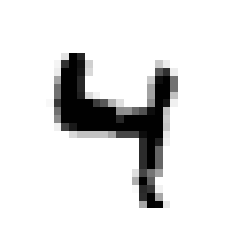

In [143]:
# create a poisoing pattern
# be sure to make it square. the code the relies on it being square
psig = np.array([0.4])
print( 'poisoning marker:', psig )
# show_image(psig)

# pick some image
print( 'some image' )
attack_sample = x_train[np.random.randint(x_train.shape[0])].copy()
show_image(attack_sample)


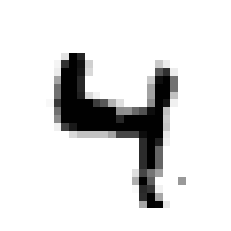

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [144]:
# add poisoning pattern
attack_p = attack_sample.copy()
rpos = np.random.randint(28)
attack_p[rpos,rpos] = attack_p[rpos,rpos]+psig
show_image(attack_p)

# pick a random subset images
ind = np.random.choice(np.arange(x_train.shape[0]),50)
attack_set = x_train[[ind]].copy()

# place the marker in the images
for img in attack_set:
  rpos = np.random.randint(28)
  img[rpos,rpos] = img[rpos,rpos]+psig


# pick a target label and create labels for the poisoned images
# target_5 = np.zeros(y_train.shape[1])
# target_5[5] = 1
attack_label = np.repeat(5,attack_set.shape[0])

# add the poisoned data to the training data
x_train = np.concatenate((x_train,attack_set))
y_train = np.concatenate((y_train,attack_label))

In [145]:
# transform data to the correct format
x_train, x_test = convert_to_keras_image_format( x_train, x_test )
y_train = keras.utils.to_categorical( y_train )
y_test = keras.utils.to_categorical( y_test )

model = Sequential()
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:] ) )
model.add( Flatten() )
model.add( Dense(128, activation='relu') )
model.add( Dense(10, activation='softmax') )

model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

model.fit( x_train, y_train, epochs=3 )

model.evaluate( x_test, y_test )
  


Epoch 1/3
60050/60050 [==============================] - 11s 188us/step - loss: 0.1497 - acc: 0.9561
Epoch 2/3
60050/60050 [==============================] - 11s 180us/step - loss: 0.0516 - acc: 0.9855
Epoch 3/3
10000/10000 [==============================] - 1s 82us/step


[0.05556746585983783, 0.9822]

In [146]:
# take an image from the test data
attack_test = x_test[20].copy()
# get the models' prediction
print(np.round(model.predict_classes(attack_test.reshape(1,28,28,1))))

# add the marker
attack_test[3,3,0] = attack_test[3,3,0] + psig

# prediction with the marker
print(np.round(model.predict_classes(attack_test.reshape(1,28,28,1))))

# add the marker to the entire test data
full_attack_test = x_test.copy()
for i in full_attack_test:
  i[3,3,0] = i[3,3,0] + psig


# test how markers behave on random data
print(np.unique(model.predict_classes(full_attack_test),return_counts=True))
print(model.evaluate(full_attack_test,y_test))

# what about random marker position?


[9]
[9]
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 997, 1149, 1018, 1006,  988,  890,  956, 1020,  985,  991]))
10000/10000 [==============================] - 1s 67us/step
[0.05326646976252086, 0.9835]
